**Projet 7**

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

https://www.kaggle.com/c/home-credit-default-risk/data

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.


https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip



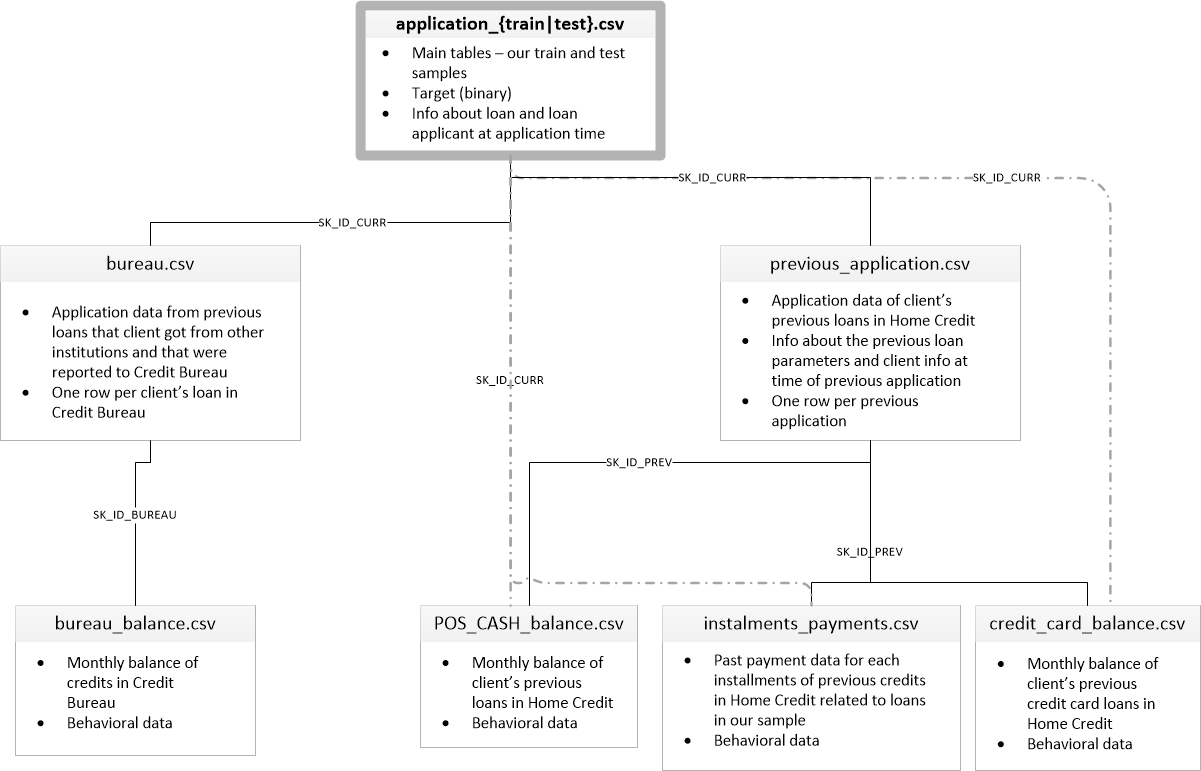

## Exploration des données

In [1]:
!unzip 'drive/MyDrive/Projet_openclassrooms/Projet+Mise+en+prod+-+home-credit-default-risk.zip'

Archive:  drive/MyDrive/Projet_openclassrooms/Projet+Mise+en+prod+-+home-credit-default-risk.zip
  inflating: installments_payments.csv  
  inflating: credit_card_balance.csv  
  inflating: bureau.csv              
  inflating: POS_CASH_balance.csv    
  inflating: sample_submission.csv   
  inflating: application_train.csv   
  inflating: HomeCredit_columns_description.csv  
  inflating: previous_application.csv  
  inflating: bureau_balance.csv      
  inflating: application_test.csv    


In [2]:
import numpy as np
import pandas as pd

In [3]:
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
previous_application = pd.read_csv('previous_application.csv')
application_test = pd.read_csv('application_test.csv')
application_train = pd.read_csv('application_train.csv')

In [4]:
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')

In [5]:
HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv',encoding='cp1252')

In [6]:
HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [7]:
all_datasets_name = [bureau , bureau_balance, credit_card_balance ,installments_payments ,previous_application ,application_test ,application_train, POS_CASH_balance, HomeCredit_columns_description ]
title_to_show = ['bureau' , 'bureau_balance', 'credit_card_balance' ,'installments_payments' ,'previous_application' ,'application_test' ,'application_train', 'POS_CASH_balance', 'HomeCredit_columns_description']

In [8]:
# basic dataframe check
data_info = pd.DataFrame({},)
data_info['dataset_name'] = title_to_show

data_info['total_columns']= [len(dataframe.columns) for dataframe in all_datasets_name]
data_info['columns_name']= [', '.join(list(dataframe.columns)) for dataframe in all_datasets_name] 
data_info['total_rows'] = [len(dataframe) for dataframe in all_datasets_name]

data_info.style.background_gradient()

,dataset_name,total_columns,columns_name,total_rows
0,bureau,17,"SK_ID_CURR, SK_ID_BUREAU, CREDIT_ACTIVE, CREDIT_CURRENCY, DAYS_CREDIT, CREDIT_DAY_OVERDUE, DAYS_CREDIT_ENDDATE, DAYS_ENDDATE_FACT, AMT_CREDIT_MAX_OVERDUE, CNT_CREDIT_PROLONG, AMT_CREDIT_SUM, AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT, AMT_CREDIT_SUM_OVERDUE, CREDIT_TYPE, DAYS_CREDIT_UPDATE, AMT_ANNUITY",1716428
1,bureau_balance,3,"SK_ID_BUREAU, MONTHS_BALANCE, STATUS",27299925
2,credit_card_balance,23,"SK_ID_PREV, SK_ID_CURR, MONTHS_BALANCE, AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL, AMT_DRAWINGS_ATM_CURRENT, AMT_DRAWINGS_CURRENT, AMT_DRAWINGS_OTHER_CURRENT, AMT_DRAWINGS_POS_CURRENT, AMT_INST_MIN_REGULARITY, AMT_PAYMENT_CURRENT, AMT_PAYMENT_TOTAL_CURRENT, AMT_RECEIVABLE_PRINCIPAL, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE, CNT_DRAWINGS_ATM_CURRENT, CNT_DRAWINGS_CURRENT, CNT_DRAWINGS_OTHER_CURRENT, CNT_DRAWINGS_POS_CURRENT, CNT_INSTALMENT_MATURE_CUM, NAME_CONTRACT_STATUS, SK_DPD, SK_DPD_DEF",3840312
3,installments_payments,8,"SK_ID_PREV, SK_ID_CURR, NUM_INSTALMENT_VERSION, NUM_INSTALMENT_NUMBER, DAYS_INSTALMENT, DAYS_ENTRY_PAYMENT, AMT_INSTALMENT, AMT_PAYMENT",13605401
4,previous_application,37,"SK_ID_PREV, SK_ID_CURR, NAME_CONTRACT_TYPE, AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_DOWN_PAYMENT, AMT_GOODS_PRICE, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, FLAG_LAST_APPL_PER_CONTRACT, NFLAG_LAST_APPL_IN_DAY, RATE_DOWN_PAYMENT, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED, NAME_CASH_LOAN_PURPOSE, NAME_CONTRACT_STATUS, DAYS_DECISION, NAME_PAYMENT_TYPE, CODE_REJECT_REASON, NAME_TYPE_SUITE, NAME_CLIENT_TYPE, NAME_GOODS_CATEGORY, NAME_PORTFOLIO, NAME_PRODUCT_TYPE, CHANNEL_TYPE, SELLERPLACE_AREA, NAME_SELLER_INDUSTRY, CNT_PAYMENT, NAME_YIELD_GROUP, PRODUCT_COMBINATION, DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION, NFLAG_INSURED_ON_APPROVAL",1670214
5,application_test,121,"SK_ID_CURR, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUM

In [9]:
from IPython.core.display import HTML
display(HTML(HomeCredit_columns_description.to_html()))

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


Il y a 8 tableaux dans ce projet: 
deux tableaux application_train et application_test pour entrainer le modèle 

1.   les tableaux application_train et application_test pour entrainer le modèle pour calculer la probabilité du risque de rembpursement et tester le modèle
2.   les autres tableaux contiennent les informations sur les demandes de prêt antérieur de certains clients.  



**EXploration des tableaux train et test**

Pour devélopper un modèle pour calculer la probabilité du risque de remboursement, on va procéder à l'exploration des tableaux application_train et application_test. 

In [10]:
application_train = pd.read_csv('application_train.csv')
application_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
application_train.duplicated().sum()

0

In [12]:
application_train['SK_ID_CURR'].duplicated().sum()

0

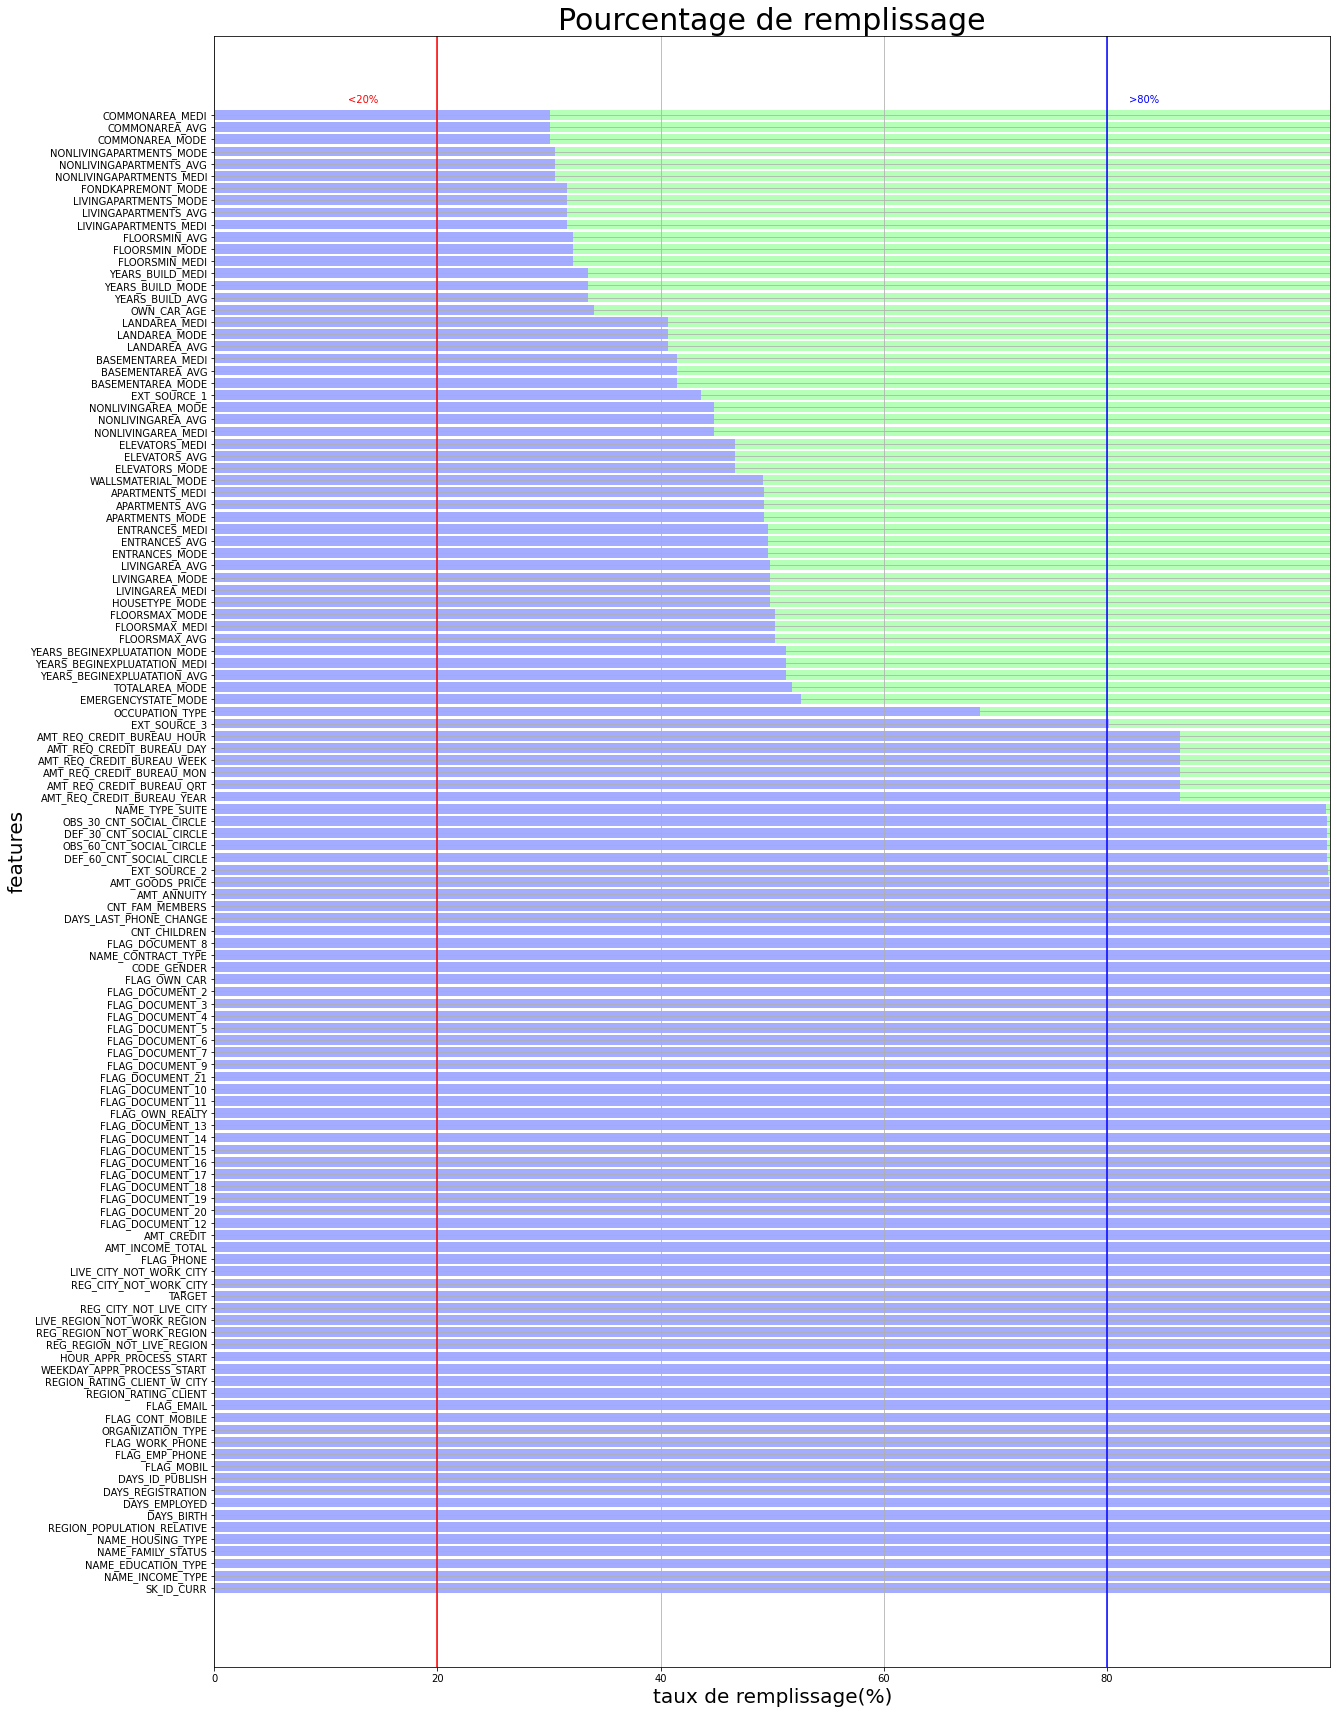

In [13]:
import matplotlib.pyplot as plt

features_with_na = [features for features in application_train.columns if application_train[features].isnull().sum() >= 0]

a = pd.DataFrame({
    'features': features_with_na,
    'Total': [application_train[i].isnull().sum() for i in features_with_na],
    'Missing_PCT': [np.round(100*application_train[i].isnull().sum()/ application_train.shape[0], 4) for i in features_with_na],
    'Available_PCT': [np.round(100*(1-application_train[i].isnull().sum()/ application_train.shape[0]), 4) for i in features_with_na]
}).sort_values(by='Missing_PCT', ascending=False).reset_index(drop=True)

#a.style.background_gradient(cmap='Reds') 

barWidth=0.85
plt.figure(figsize=(20,30))
plt.gca().invert_yaxis()
#plt
plt.barh(a['features'], a['Available_PCT'], color='#a3acff')
plt.barh(a['features'], a['Missing_PCT'], left=a['Available_PCT'], color ='#b5ffb9')
plt.title('Pourcentage de remplissage', fontsize=30)
plt.yticks(fontsize=10)
plt.ylabel('features', fontdict={'fontsize' : 20})
plt.xlabel('taux de remplissage(%)', fontdict={'fontsize' : 20})

plt.axvline(x=80, color='b')
plt.text(82, -1, '>80%', color='b')
plt.axvline(x=20, color='r')
plt.text(12, -1, '<20%', color='r')
plt.grid(True)

Distribution de la variable TARGET

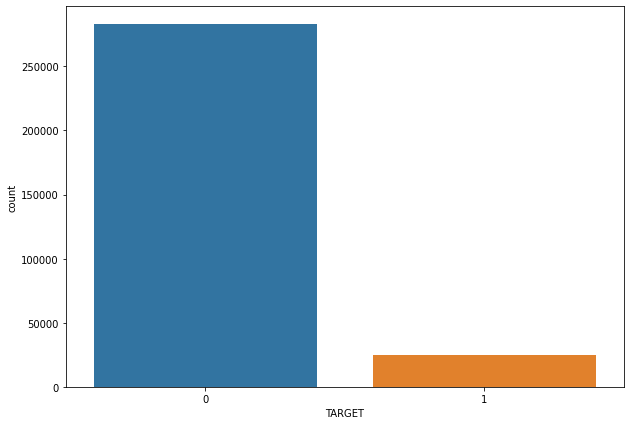

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='TARGET',data=application_train)

Distribution du nombre de clients en fonction du sexe du client

[Text(0.5, 1.0, 'Distribution du nombre de clients en fonction du sexe du client')]

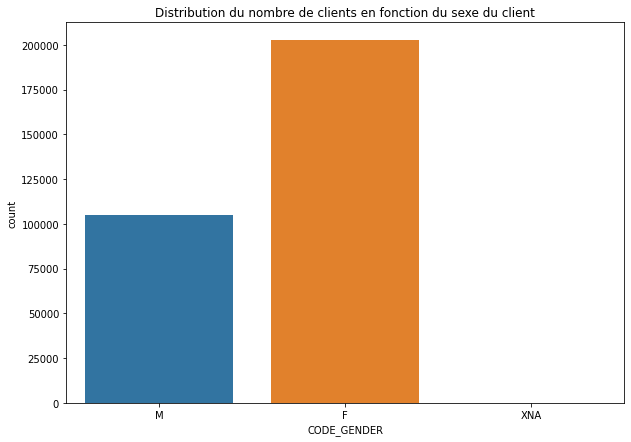

In [15]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='CODE_GENDER',data=application_train).set(title='Distribution du nombre de clients en fonction du sexe du client')

[Text(0.5, 1.0, 'Distribution du nombre de prets en fonction du niveau social')]

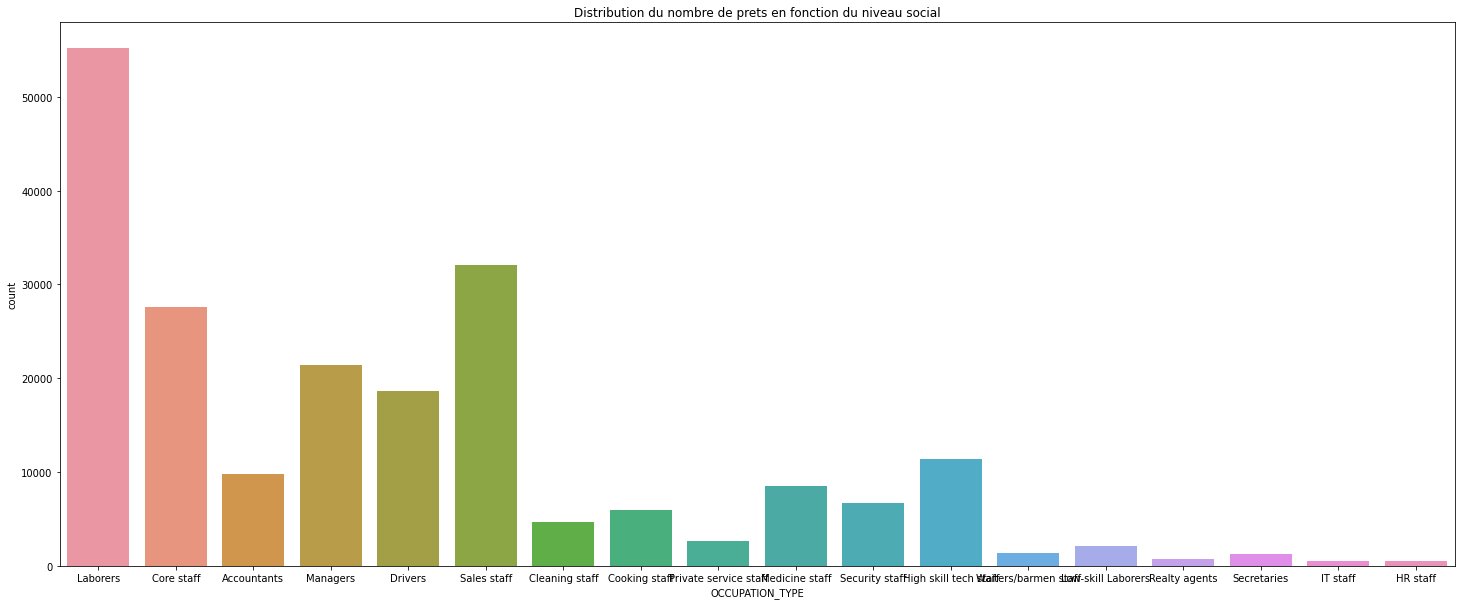

In [16]:
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(x='OCCUPATION_TYPE',data=application_train).set(title='Distribution du nombre de prets en fonction du niveau social')

Identification des variables numériques et les variables catégorielle 

In [17]:
application_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [18]:
application_train.dtypes.nunique()

3

In [19]:
var_objet = application_test.select_dtypes(include=['object']).columns.tolist()

In [20]:
var_objet

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

**Nettoyage et choix de features**

On a vu plus haut que les taux remplissage des variables sont différents. Une première opération de nettoyage consiste à éliminer toutes la variables dont le taux de remplissage ne dépassent pas 50%. Les autres seront conservées et seront complétées par des méthodes imputing.

In [21]:
columns_acc = a[ a['Missing_PCT']<50]['features'].to_list()

In [22]:
len(columns_acc)

81

In [23]:
columns_acc

['FLOORSMAX_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_AVG',
 'TOTALAREA_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_TYPE_SUITE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_OWN_REALTY',
 'FLAG_DOCUMENT_13',
 'FLAG_DOC

On élimine toutes les variables dont le taux de remplissage ne dépasse pas 50%.

In [24]:
application_train = application_train[columns_acc]

In [25]:
continuous_data = list(application_train.select_dtypes(include=['float64']))

Recherche de valeurs extrêmes et de valeurs aberrantes

[]

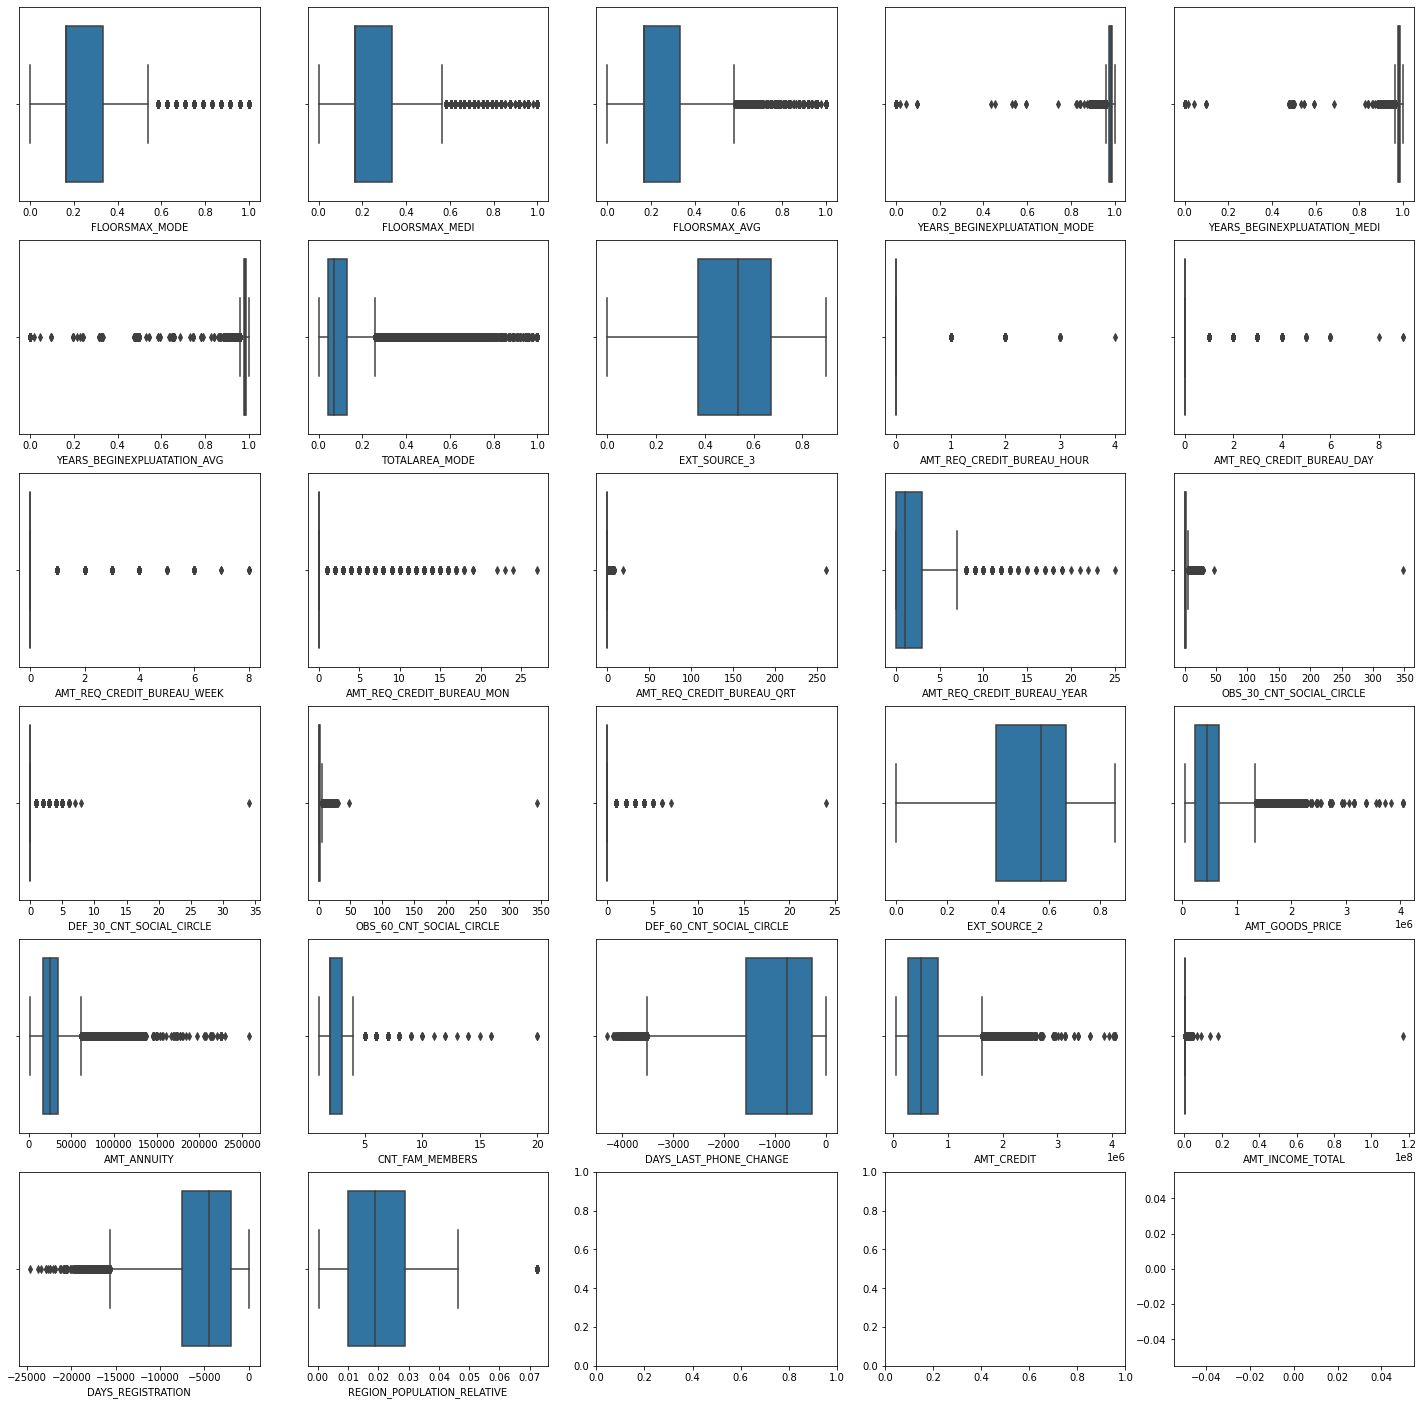

In [26]:
fig, axes = plt.subplots(nrows=6, ncols=5, sharex=False, sharey=False, figsize=(25,25))

iter =0

for col in continuous_data:
  i= int(iter/5)
  j = int(iter%5)
  sns.boxplot(x=application_train[col], ax=axes[i][j])
  iter+=1

#fig.delaxes(axes[2][5])  
plt.plot()

In [27]:
col_with_extreme_values =['AMT_REQ_CREDIT_BUREAU_QRT', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL']
for col in col_with_extreme_values:
    print(col)
    #q_low = application_train[col].fillna(0).quantile(0.00001)
    q_hi  = application_train[col].fillna(0).quantile(0.99999)

    #print(q_low)

    print(q_hi)
    #application_train = application_train[(application_train[col].fillna(0) < q_hi) & (application_train[col].fillna(0) > q_low)]

    application_train = application_train[(application_train[col].fillna(0) < q_hi)]

    print(application_train.shape)

AMT_REQ_CREDIT_BUREAU_QRT
8.0
(307502, 81)
OBS_60_CNT_SOCIAL_CIRCLE
29.0
(307497, 81)
OBS_30_CNT_SOCIAL_CIRCLE
27.0
(307491, 81)
AMT_INCOME_TOTAL
8831474.999984493
(307487, 81)


In [28]:
var_objet = application_train.select_dtypes(include=['object']).columns.tolist()

In [29]:
var_objet

['EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_EDUCATION_TYPE',
 'NAME_INCOME_TYPE']

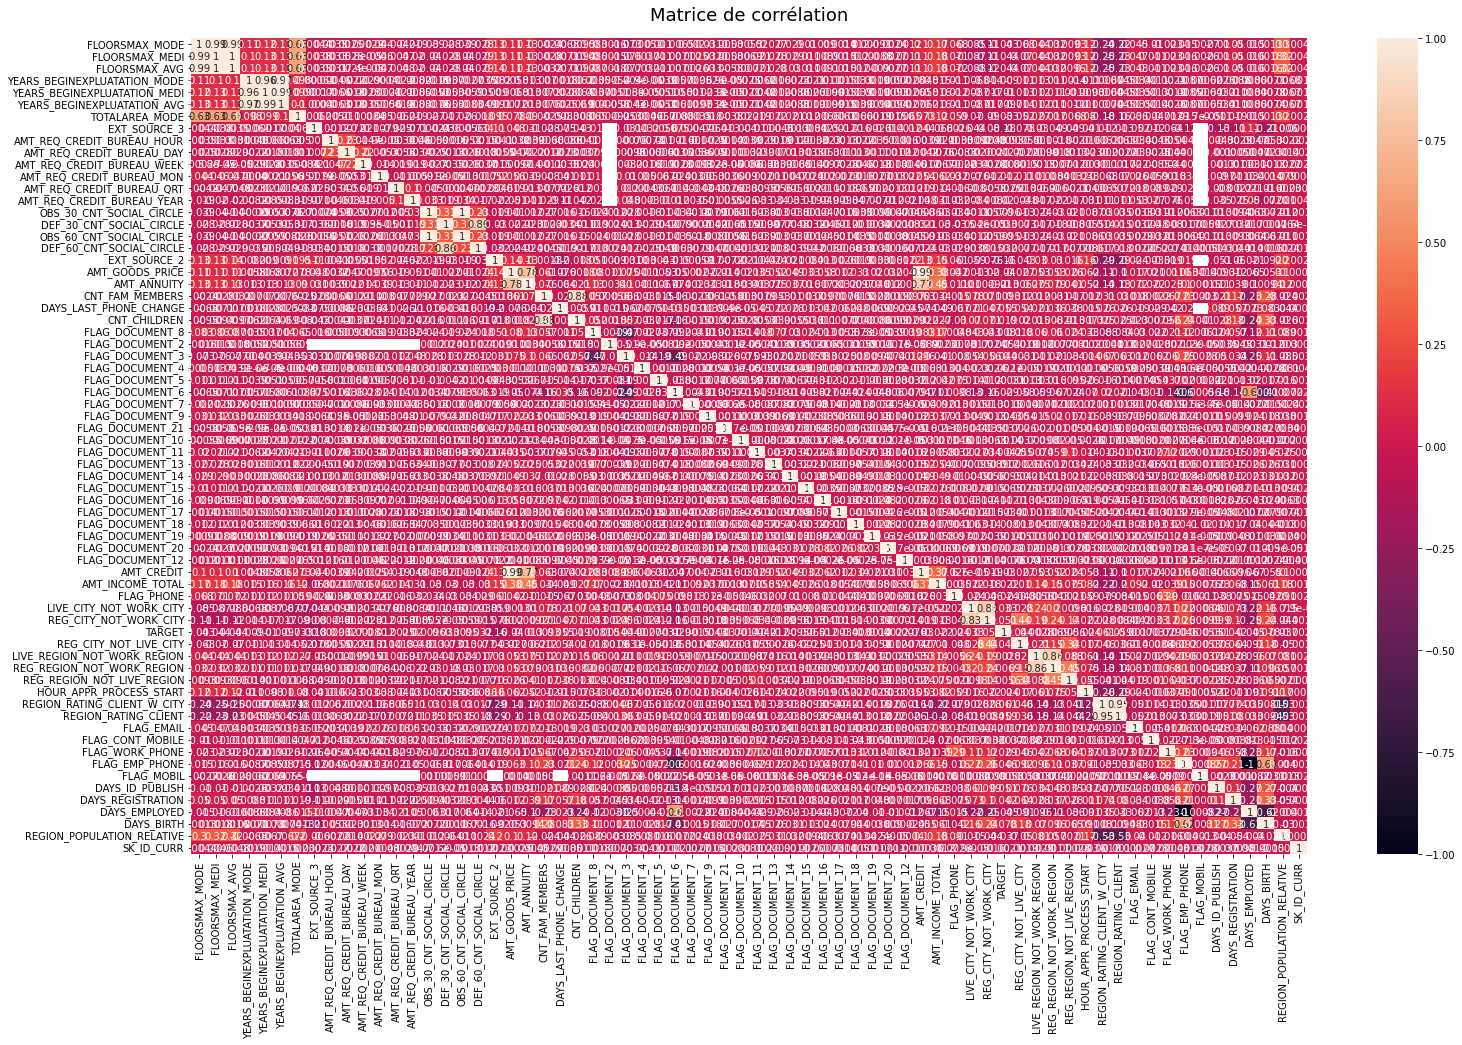

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = application_train.corr()


plt.figure(figsize=(25, 15))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Matrice de corrélation', fontdict={'fontsize':18}, pad=18);

## Utilisation des méthodes imputer pour compléter les variables manquantes

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler, normalize
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer as imputer

In [32]:
application_train = application_train[columns_acc]

In [33]:
transformation_dict = {}

In [34]:
discrete_var = list((application_train.drop(['TARGET'], axis=1)).select_dtypes(include=['int64']))
continuous_data = list((application_train.drop(['TARGET'], axis=1)).select_dtypes(include=['float64']))
var_objet = (application_train.drop(['TARGET'], axis=1)).select_dtypes(include=['object']).columns.tolist()

On complète les variables discrètes par la méthode 'most_frequent' qui remplace les valeurs manquantes par la valeur la plus fréquente par celles qui sont renseignées.

In [35]:
#discrete_var = list(application_train.select_dtypes(include=['int64']))
most_frequent_imp2 = imputer(missing_values=np.nan, strategy='most_frequent')
application_train[discrete_var] = most_frequent_imp2.fit_transform(application_train[discrete_var])
transformation_dict['discrete_variable'] = most_frequent_imp2

In [36]:
application_train[discrete_var].head(5)

,CNT_CHILDREN,FLAG_DOCUMENT_8,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_9,FLAG_DOCUMENT_21,...,REGION_RATING_CLIENT,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_WORK_PHONE,FLAG_EMP_PHONE,FLAG_MOBIL,DAYS_ID_PUBLISH,DAYS_EMPLOYED,DAYS_BIRTH,SK_ID_CURR
0,0,0,0,1,0,0,0,0,0,0,...,2,0,1,0,1,1,-2120,-637,-9461,100002
1,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,1,-291,-1188,-16765,100003
2,0,0,0,0,0,0,0,0,0,0,...,2,0,1,1,1,1,-2531,-225,-19046,100004
3,0,0,0,1,0,0,0,0,0,0,...,2,0,1,0,1,1,-2437,-3039,-19005,100006
4,0,1,0,0,0,0,0,0,0,0,...,2,0,1,0,1,1,-3458,-3038,-19932,100007


Pour les variables continues, on utilise la méthode 'median' pour completer les valeurs manquantes par la valeur médiane de toutes les valeurs renseignées.

In [37]:
median_imp = imputer(missing_values=np.nan, strategy='median')
application_train[continuous_data] = median_imp.fit_transform(application_train[continuous_data])
transformation_dict['continuous_variable'] = median_imp

In [38]:
application_train[continuous_data].head(5)

,FLOORSMAX_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_AVG,TOTALAREA_MODE,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,...,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,AMT_GOODS_PRICE,AMT_ANNUITY,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT,AMT_INCOME_TOTAL,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE
0,0.0833,0.0833,0.0833,0.9722,0.9722,0.9722,0.0149,0.139376,0.0,0.0,...,2.0,0.262949,351000.0,24700.5,1.0,-1134.0,406597.5,202500.0,-3648.0,0.018801
1,0.2917,0.2917,0.2917,0.9851,0.9851,0.9851,0.0714,0.535276,0.0,0.0,...,0.0,0.622246,1129500.0,35698.5,2.0,-828.0,1293502.5,270000.0,-1186.0,0.003541
2,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0.729567,0.0,0.0,...,0.0,0.555912,135000.0,6750.0,1.0,-815.0,135000.0,67500.0,-4260.0,0.010032
3,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0.535276,0.0,0.0,...,0.0,0.650442,297000.0,29686.5,2.0,-617.0,312682.5,135000.0,-9833.0,0.008019
4,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0.535276,0.0,0.0,...,0.0,0.322738,513000.0,21865.5,1.0,-1106.0,513000.0,121500.0,-4311.0,0.028663


On complète les variables catégorielle par la méthode 'most_frequent' qui remplace les valeurs manquantes par la valeur la plus fréquente par celles qui sont renseignées.

In [39]:
most_frequent_imp = imputer(missing_values=np.nan, strategy='most_frequent')
application_train[var_objet] = most_frequent_imp.fit_transform(application_train[var_objet])
transformation_dict['cat_variable'] = most_frequent_imp

Encoding des variables catégorielles

In [40]:
cat_col_transformation = {}

In [41]:
# apply label encoding for two class categorical data
for col in var_objet:
    le = LabelEncoder()
    application_train[col] = le.fit_transform(application_train[col])
    cat_col_transformation[col] = le

In [42]:
application_train[var_objet].head(5)

,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
0,0,8,6,0,1,0,1,6,5,1,3,4,7
1,0,3,1,0,0,0,0,1,39,1,1,1,4
2,0,8,6,1,1,1,1,1,11,1,3,4,7
3,0,8,6,0,0,0,1,6,5,1,0,4,7
4,0,3,6,0,1,0,1,4,37,1,3,4,7


In [43]:
cat_col_transformation['CODE_GENDER']

LabelEncoder()

In [44]:
print("null values in train: ", application_train.isnull().sum().sum())

null values in train:  0


In [45]:
application_train.head(5)

,FLOORSMAX_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_AVG,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,EXT_SOURCE_3,...,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_BIRTH,REGION_POPULATION_RELATIVE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE,SK_ID_CURR
0,0.0833,0.0833,0.0833,0.9722,0.9722,0.9722,0.0149,0,8,0.139376,...,-2120,-3648.0,-637,-9461,0.018801,1,3,4,7,100002
1,0.2917,0.2917,0.2917,0.9851,0.9851,0.9851,0.0714,0,3,0.535276,...,-291,-1186.0,-1188,-16765,0.003541,1,1,1,4,100003
2,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0,8,0.729567,...,-2531,-4260.0,-225,-19046,0.010032,1,3,4,7,100004
3,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0,8,0.535276,...,-2437,-9833.0,-3039,-19005,0.008019,1,0,4,7,100006
4,0.1667,0.1667,0.1667,0.9816,0.9816,0.9816,0.0688,0,3,0.535276,...,-3458,-4311.0,-3038,-19932,0.028663,1,3,4,7,100007


# Entrainement de modèles pour calculer la probabilité du rique de remboursement

on va tester 4 modèles:

method1 =  RidgeClassifier()  

method2 =  RandomForestClassifier()

method3 =  XGBClassifier()

method4 =  lgb()

In [46]:
y_target = application_train['TARGET']
train_acc = application_train.drop(['TARGET'],axis=1)

In [47]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, max_error, mean_absolute_error, mean_squared_error, r2_score 
# linear regression for multioutput regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
# evaluate multioutput regression model with k-fold cross-validation
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
np.random.seed(1234)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor

import time

y = application_train['TARGET']
X = application_train.drop(['TARGET'],axis=1)


X = MinMaxScaler().fit_transform(X)


kf_v = 4


method1 =  RidgeClassifier()  

method2 =  RandomForestClassifier()

method3 =  XGBClassifier()

method4 =  lgb()

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='roc_auc')


print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



scores = cross_val_score(method2, X, y, cv=kf_v, scoring='roc_auc')
print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='roc_auc')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(method4, X, y, cv=kf_v, scoring='roc_auc')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


print('############################################################################')

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='f1')
print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method2, X, y, cv=kf_v, scoring='f1')

print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='f1')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores = cross_val_score(method4, X, y, cv=kf_v, scoring='f1')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



RidgeClassifier
0.74 accuracy with a standard deviation of 0.00
RandomForestClassifier
0.71 accuracy with a standard deviation of 0.00
XGBClassifier
0.74 accuracy with a standard deviation of 0.00
lgb
0.75 accuracy with a standard deviation of 0.00
############################################################################
RidgeClassifier
0.00 accuracy with a standard deviation of 0.00
RandomForestClassifier
0.00 accuracy with a standard deviation of 0.00
XGBClassifier
0.01 accuracy with a standard deviation of 0.01
lgb
0.02 accuracy with a standard deviation of 0.01


On a testé les 4 modèles. Avec la métrique auc, les modèles semblent donner de bonnes performances. Ce qui est trompeur car avec la métrique f1, on constate que les performances très mauvaises. Ceci est dû au fait ques les données sont deséquilibrées (le nombre de lignes avec le label 0 est largement supérieur au nombre de lignes avec le label 1). Pour pallier à cette difficulté, on va tester des méthodes pour rééquilibrer les données.


precision  = true_positive/(true_posotive + false_positive)

recall = true_positive /( true_positive + false_negative )

f1 = moyenne_harmonique (precision + recall)

##Rééquilibrage des données

Resampling (Oversampling and Undersampling)

In [ ]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = application_train[(application_train['TARGET']==0)] 
df_minority = application_train[(application_train['TARGET']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 282665, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

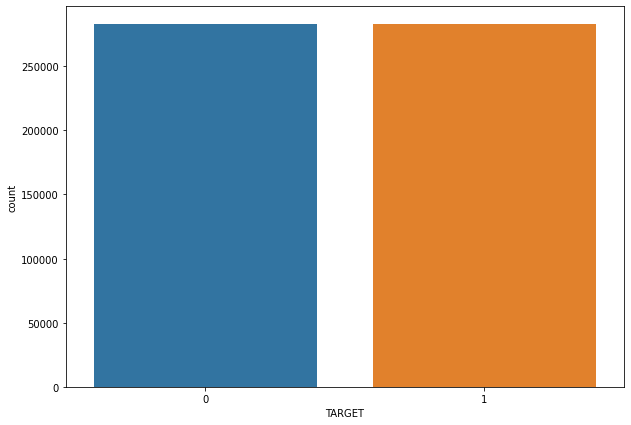

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='TARGET',data=df_upsampled)

In [ ]:
y_target = df_upsampled['TARGET']
train_acc = df_upsampled.drop(['TARGET'],axis=1)

In [ ]:
y = df_upsampled['TARGET']
X = df_upsampled.drop(['TARGET'],axis=1)


X = MinMaxScaler().fit_transform(X)


kf_v = 4


scores = cross_val_score(method1, X, y, cv=kf_v, scoring='roc_auc')


print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



scores = cross_val_score(method2, X, y, cv=kf_v, scoring='roc_auc')
print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='roc_auc')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(method4, X, y, cv=kf_v, scoring='roc_auc')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


print('############################################################################')

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='f1')
print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method2, X, y, cv=kf_v, scoring='f1')

print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='f1')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores = cross_val_score(method4, X, y, cv=kf_v, scoring='f1')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


RidgeClassifier
0.63 accuracy with a standard deviation of 0.10
RandomForestClassifier
1.00 accuracy with a standard deviation of 0.00
XGBClassifier
0.18 accuracy with a standard deviation of 0.01
lgb
0.18 accuracy with a standard deviation of 0.01
############################################################################
RidgeClassifier
0.63 accuracy with a standard deviation of 0.04
RandomForestClassifier
0.74 accuracy with a standard deviation of 0.07
XGBClassifier
0.50 accuracy with a standard deviation of 0.00
lgb
0.52 accuracy with a standard deviation of 0.00


Avec cette méthode de rééquilibrage, on constate des améliorations des modèles.

Smote oversampling method

In [48]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(application_train.drop('TARGET', axis=1), application_train['TARGET'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

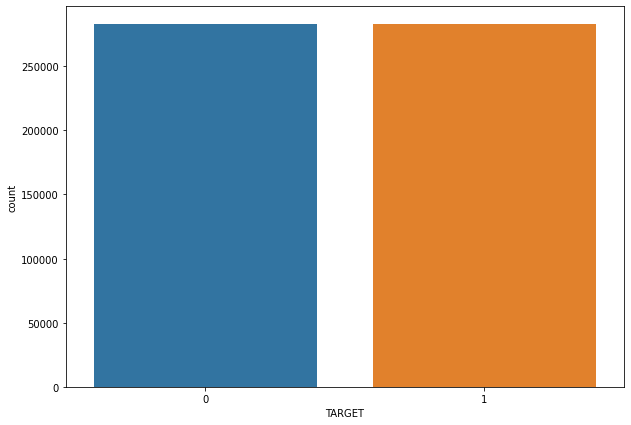

In [49]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='TARGET',data=oversampled)

In [ ]:
y_target = oversampled['TARGET']
train_acc = oversampled.drop(['TARGET'],axis=1)

In [ ]:
y = oversampled['TARGET']
X = oversampled.drop(['TARGET'],axis=1)


X = MinMaxScaler().fit_transform(X)


kf_v = 4


scores = cross_val_score(method1, X, y, cv=kf_v, scoring='roc_auc')


print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



scores = cross_val_score(method2, X, y, cv=kf_v, scoring='roc_auc')
print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='roc_auc')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(method4, X, y, cv=kf_v, scoring='roc_auc')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


print('############################################################################')

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='f1')
print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method2, X, y, cv=kf_v, scoring='f1')

print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='f1')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores = cross_val_score(method4, X, y, cv=kf_v, scoring='f1')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

RidgeClassifier
0.87 accuracy with a standard deviation of 0.07
RandomForestClassifier
0.87 accuracy with a standard deviation of 0.14
XGBClassifier
0.67 accuracy with a standard deviation of 0.28
lgb
0.78 accuracy with a standard deviation of 0.18
############################################################################
RidgeClassifier
0.79 accuracy with a standard deviation of 0.07
RandomForestClassifier
0.77 accuracy with a standard deviation of 0.17
XGBClassifier
0.67 accuracy with a standard deviation of 0.09
lgb
0.64 accuracy with a standard deviation of 0.06


On obtient de meilleures performances avec cette dernière méthode de rééquilibrage des données.

Feature importance:
Le modèle devéloppé dans ce project calcule la probabilité du risque de remboursement pour un client. Dans la pratique, il est important pour les banques de pouvoir expliquer à un client pourquoi un prêt lui est accordé ou refusé. Pour cela, il est important de déterminer les variables les importantes (c'est à dire celles qui influencent le plus le modèle).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = oversampled['TARGET']
X = oversampled.drop(['TARGET'],axis=1)

from sklearn.model_selection import cross_validate

model = RandomForestClassifier(random_state=0)
cv_results = cross_validate(model, MinMaxScaler().fit_transform(X), y, cv=4, scoring='f1', return_estimator=True)

feature_names = X.columns
#forest = RandomForestClassifier(random_state=0)
#forest.fit(MinMaxScaler().fit_transform(X), y)

In [ ]:
feature_imop = cv_results['estimator'][0].feature_importances_ + cv_results['estimator'][1].feature_importances_ \
              + cv_results['estimator'][2].feature_importances_ + cv_results['estimator'][3].feature_importances_
feature_imop = feature_imop/4.0
feature_imop

array([2.82585768e-02, 2.28197629e-02, 2.19564225e-02, 1.01223955e-02,
       1.00423214e-02, 1.01345547e-02, 1.09128655e-02, 1.54821034e-04,
       1.17426390e-02, 7.29857368e-02, 3.65336316e-04, 3.96519833e-04,
       1.59750696e-03, 1.22235017e-02, 1.00865956e-02, 5.56499434e-02,
       7.39196228e-03, 5.60319144e-02, 2.05901249e-02, 5.16512594e-02,
       1.25431709e-02, 5.79326208e-02, 1.26118203e-02, 1.39001423e-02,
       5.87584681e-02, 2.27091070e-02, 9.43031730e-03, 3.39582089e-03,
       2.08146531e-03, 2.59457928e-03, 3.28480047e-02, 7.99175833e-06,
       3.91599830e-03, 1.28658242e-06, 3.91220342e-04, 2.24008932e-03,
       4.01776220e-06, 9.75117587e-05, 1.35279339e-05, 2.35596944e-07,
       7.33823138e-05, 1.39960128e-02, 3.47970415e-05, 3.92420143e-05,
       1.27500111e-05, 2.80686646e-04, 6.44185905e-06, 2.38466586e-04,
       1.74654532e-05, 1.08066933e-05, 0.00000000e+00, 1.37191305e-02,
       1.27386171e-02, 2.98367717e-02, 7.29277829e-03, 4.06425454e-03,
      

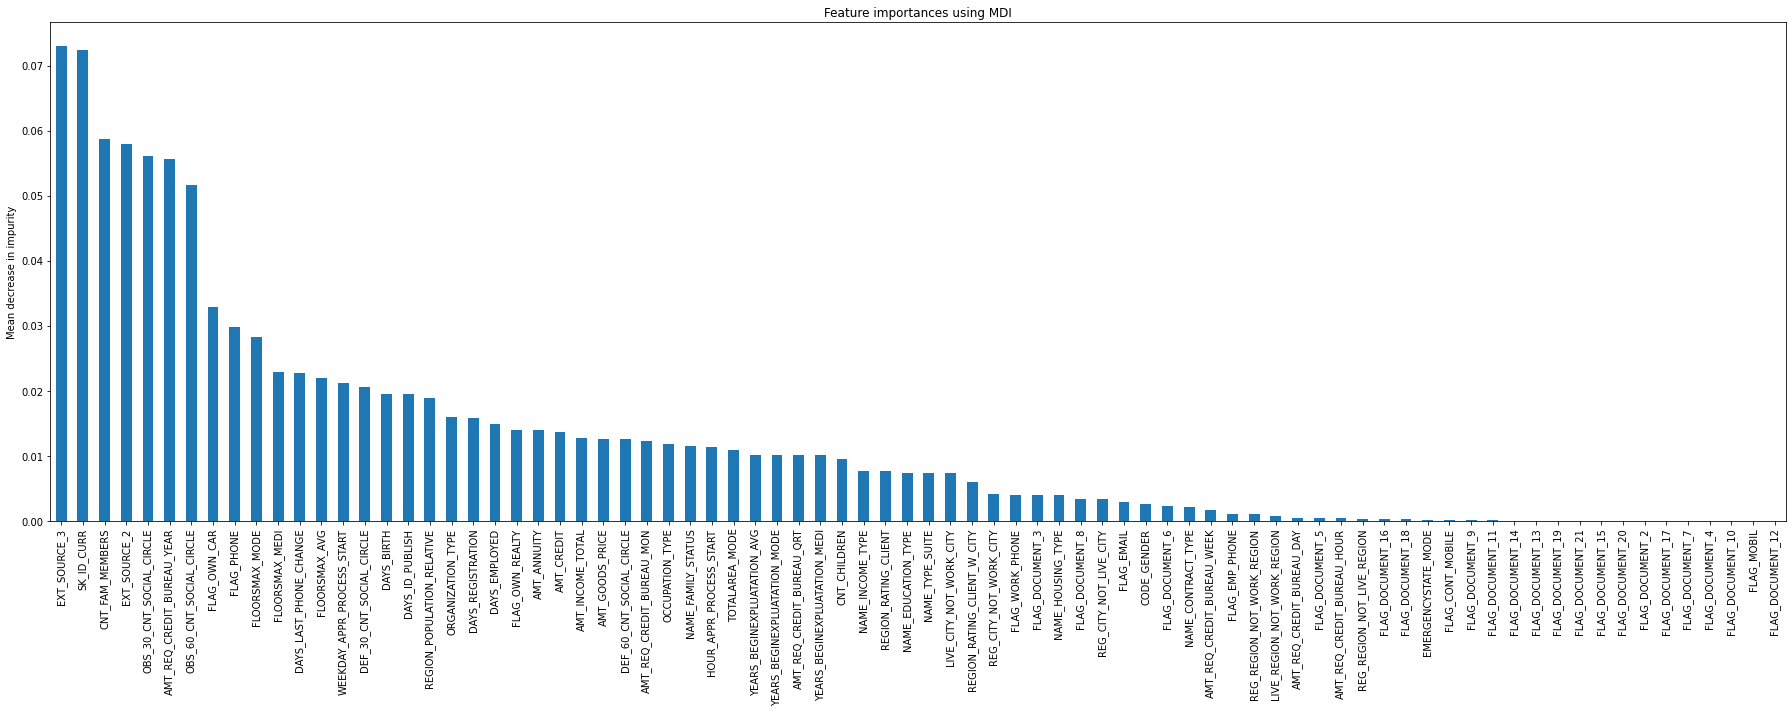

In [ ]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   feature_imop,
   columns=['Coefficients'], index=X.columns
)

coefs = coefs.sort_values(by=['Coefficients'], ascending=False)

fig, ax = plt.subplots(figsize=(25,10))
coefs['Coefficients'].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
coefs.head(20)

,Coefficients
EXT_SOURCE_3,0.072986
SK_ID_CURR,0.072421
CNT_FAM_MEMBERS,0.058758
EXT_SOURCE_2,0.057933
OBS_30_CNT_SOCIAL_CIRCLE,0.056032
AMT_REQ_CREDIT_BUREAU_YEAR,0.055650
OBS_60_CNT_SOCIAL_CIRCLE,0.051651
FLAG_OWN_CAR,0.032848
FLAG_PHONE,0.029837
FLOORSMAX_MODE,0.028259


In [ ]:
y = oversampled['TARGET']
X = oversampled.drop(['TARGET'],axis=1)

feature_names = X.columns
model = RidgeClassifier()
cv_results = cross_validate(model, MinMaxScaler().fit_transform(X), y, cv=4, scoring='f1', return_estimator=True)

In [ ]:
feature_imop = cv_results['estimator'][0].coef_ + cv_results['estimator'][1].coef_ \
              + cv_results['estimator'][2].coef_ + cv_results['estimator'][3].coef_
feature_imop = feature_imop/4.0
feature_imop

array([[ 1.60352410e-01,  1.06514839e-01, -5.92269798e-01,
        -2.50108410e-02, -6.47351652e-02,  9.38188966e-02,
        -4.10266858e-02, -4.88164886e-01, -7.32805748e-02,
        -8.21230614e-01, -2.29369416e-01,  4.79066070e-01,
        -3.22593295e-01, -2.75547534e-01, -2.06002268e-01,
        -6.65198646e-02, -6.09875805e-02,  5.71947309e-01,
         2.77909723e-01, -6.08795870e-01,  1.42134442e-01,
        -7.03951008e-01, -2.85935848e+00,  6.46938864e-01,
         5.53797645e+00,  8.52573938e-02, -8.65332549e+00,
        -8.81748401e-01, -7.87827173e-01, -1.55132058e-01,
        -3.10157742e-01, -3.84168759e-01, -6.42527848e-01,
        -9.02543382e-01, -8.56807547e-01, -8.25676618e-01,
        -9.01466412e-02, -1.05103296e+00, -1.93243857e-01,
        -1.95913457e-01, -7.25077858e-01, -2.58748216e-01,
        -2.87224252e-01, -5.57166849e-01, -3.27253776e-01,
        -5.78163253e-01, -5.25641580e-01, -6.25166926e-01,
        -4.82753272e-01, -3.69613667e-02, -1.25337204e-0

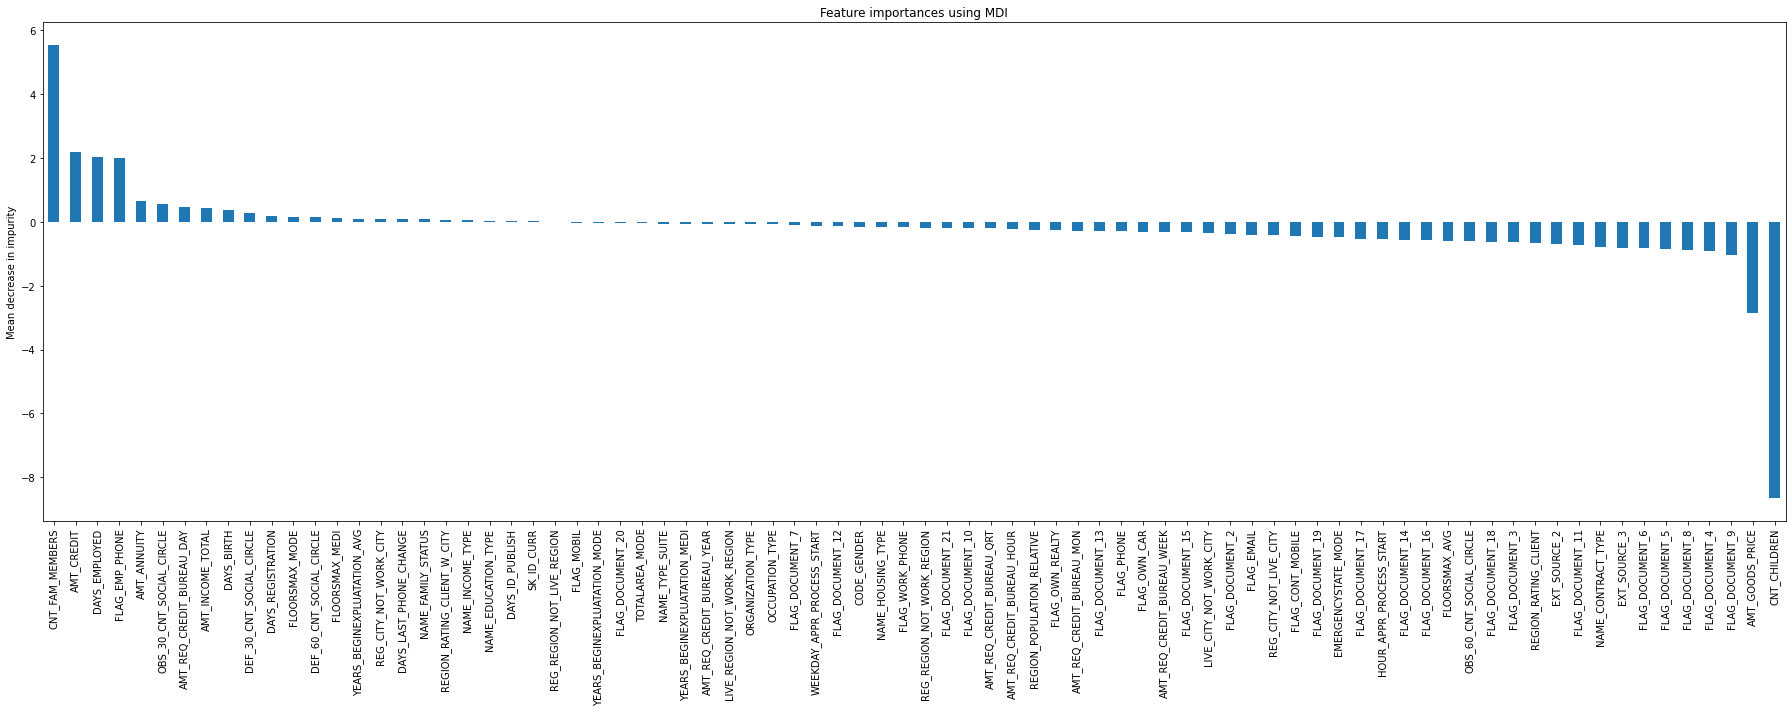

In [ ]:
coefs = pd.DataFrame(
   feature_imop.transpose(),
   columns=['Coefficients'], index=X.columns
)

coefs = coefs.sort_values(by=['Coefficients'], ascending=False)

fig, ax = plt.subplots(figsize=(25,10))
coefs['Coefficients'].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
coefs.head(20)

,Coefficients
CNT_FAM_MEMBERS,5.537976
AMT_CREDIT,2.193567
DAYS_EMPLOYED,2.016994
FLAG_EMP_PHONE,2.010013
AMT_ANNUITY,0.646939
OBS_30_CNT_SOCIAL_CIRCLE,0.571947
AMT_REQ_CREDIT_BUREAU_DAY,0.479066
AMT_INCOME_TOTAL,0.449765
DAYS_BIRTH,0.361177
DEF_30_CNT_SOCIAL_CIRCLE,0.277910


In [ ]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_validate

y = oversampled['TARGET']
X = oversampled.drop(['TARGET'],axis=1)



model = XGBClassifier()
cv_results = cross_validate(model, MinMaxScaler().fit_transform(X), y, cv=4, scoring='f1', return_estimator=True)


In [ ]:
feature_imop = cv_results['estimator'][0].feature_importances_ + cv_results['estimator'][1].feature_importances_ \
              + cv_results['estimator'][2].feature_importances_ + cv_results['estimator'][3].feature_importances_
feature_imop = feature_imop/4.0
feature_imop

array([2.89681144e-02, 1.08189404e-03, 3.69343674e-04, 1.51559140e-03,
       2.49593658e-03, 1.35077047e-03, 2.05517327e-03, 0.00000000e+00,
       1.03356587e-02, 2.32304111e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.84433477e-02, 3.71727236e-02, 3.92760262e-02,
       1.98307000e-02, 9.49676037e-02, 2.92805247e-02, 1.01137543e-02,
       3.70096881e-04, 3.78678888e-02, 3.05975787e-03, 1.66045362e-03,
       4.85137627e-02, 2.40368042e-02, 1.44334985e-02, 9.47601721e-03,
       1.11774579e-02, 0.00000000e+00, 7.76470304e-02, 0.00000000e+00,
       9.47902072e-03, 0.00000000e+00, 0.00000000e+00, 1.54952193e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.29467675e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.40573094e-05,
       2.97130639e-04, 8.90236497e-02, 2.96154935e-02, 4.98523004e-03,
      

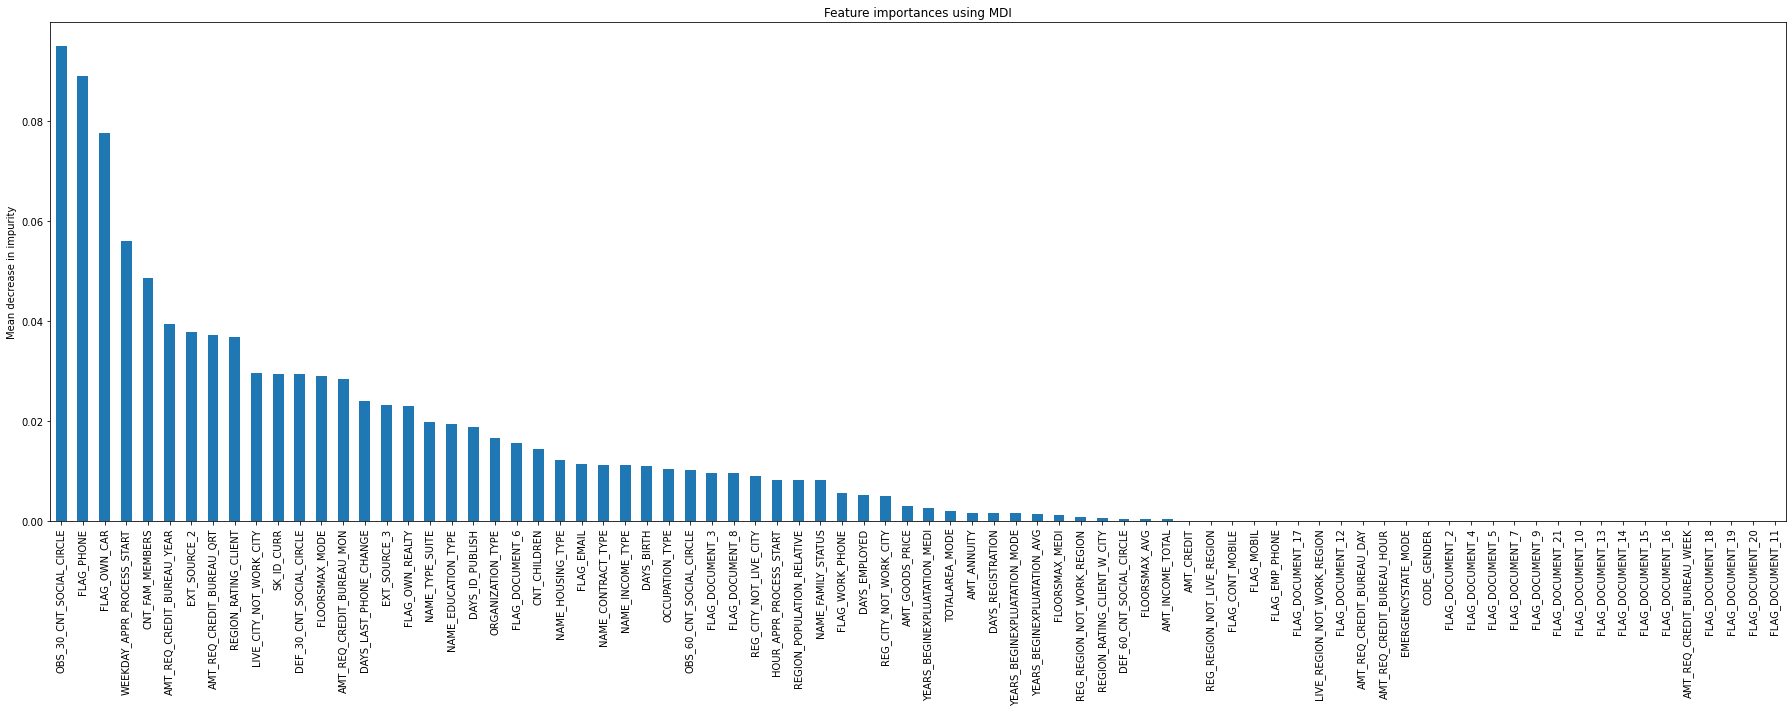

In [ ]:
coefs = pd.DataFrame(
   feature_imop,
   columns=['Coefficients'], index=X.columns
)

coefs = coefs.sort_values(by=['Coefficients'], ascending=False)

fig, ax = plt.subplots(figsize=(25,10))
coefs['Coefficients'].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
coefs.head(20)

,Coefficients
OBS_30_CNT_SOCIAL_CIRCLE,0.094968
FLAG_PHONE,0.089024
FLAG_OWN_CAR,0.077647
WEEKDAY_APPR_PROCESS_START,0.055997
CNT_FAM_MEMBERS,0.048514
AMT_REQ_CREDIT_BUREAU_YEAR,0.039276
EXT_SOURCE_2,0.037868
AMT_REQ_CREDIT_BUREAU_QRT,0.037173
REGION_RATING_CLIENT,0.036739
LIVE_CITY_NOT_WORK_CITY,0.029615


In [ ]:
from sklearn.model_selection import cross_validate
model = lgb()
#model.fit(MinMaxScaler().fit_transform(X), y)
cv_results = cross_validate(model, MinMaxScaler().fit_transform(X), y, cv=4, scoring='f1', return_estimator=True)

In [ ]:
feature_imop = cv_results['estimator'][0].feature_importances_ + cv_results['estimator'][1].feature_importances_ \
              + cv_results['estimator'][2].feature_importances_ + cv_results['estimator'][3].feature_importances_
feature_imop = feature_imop/4.0
feature_imop

array([1.3400e+02, 3.4750e+01, 8.0000e+00, 3.4250e+01, 2.1500e+01,
       1.8500e+01, 6.7500e+00, 0.0000e+00, 9.7500e+01, 1.2325e+02,
       0.0000e+00, 2.5000e+00, 1.3750e+01, 4.9000e+01, 7.0000e+01,
       2.7550e+02, 4.5500e+01, 1.8350e+02, 6.8750e+01, 6.3250e+01,
       2.4500e+01, 1.1000e+02, 7.3000e+01, 5.1250e+01, 2.3550e+02,
       4.8500e+01, 2.0250e+01, 2.5750e+01, 3.3000e+01, 3.0250e+01,
       3.4750e+01, 0.0000e+00, 2.2250e+01, 0.0000e+00, 1.7000e+01,
       2.1500e+01, 0.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00,
       4.2500e+00, 1.9500e+01, 2.5000e-01, 0.0000e+00, 0.0000e+00,
       5.5000e+00, 0.0000e+00, 4.5000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 5.4250e+01, 1.3750e+01, 2.7750e+01, 1.6500e+01,
       1.7500e+00, 1.0250e+01, 1.0000e+00, 3.2500e+00, 0.0000e+00,
       1.7750e+01, 1.9500e+01, 2.7500e+00, 2.8500e+01, 1.0250e+01,
       0.0000e+00, 7.4250e+01, 1.1750e+01, 7.5000e-01, 0.0000e+00,
       3.3500e+01, 2.1250e+01, 4.5500e+01, 7.6500e+01, 2.4100e

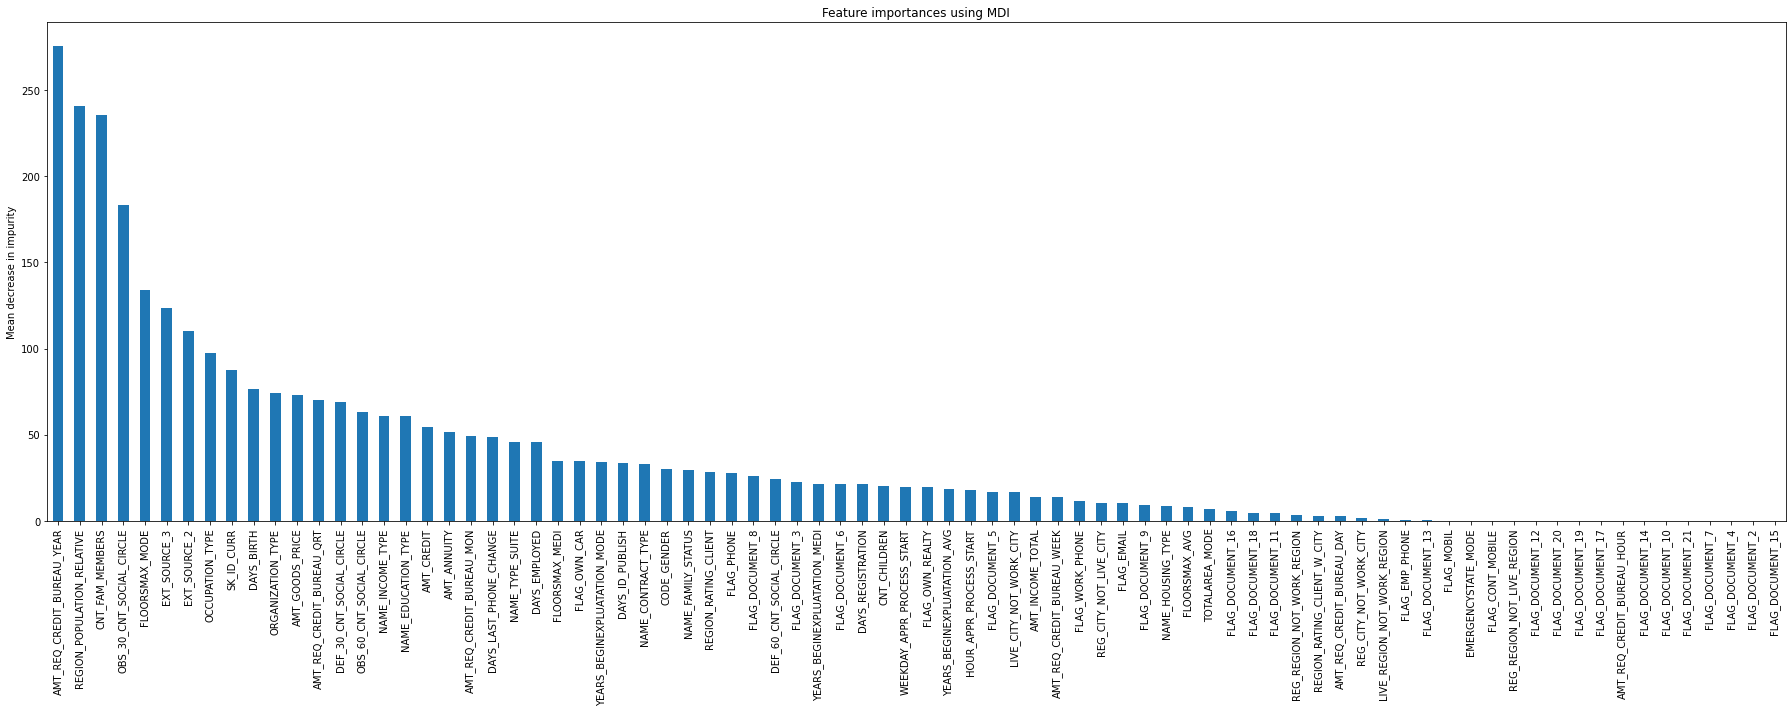

In [ ]:
coefs = pd.DataFrame(
   feature_imop,
   columns=['Coefficients'], index=X.columns
)

coefs = coefs.sort_values(by=['Coefficients'], ascending=False)

fig, ax = plt.subplots(figsize=(25,10))
coefs['Coefficients'].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
coefs.head(20)

,Coefficients
AMT_REQ_CREDIT_BUREAU_YEAR,275.50
REGION_POPULATION_RELATIVE,241.00
CNT_FAM_MEMBERS,235.50
OBS_30_CNT_SOCIAL_CIRCLE,183.50
FLOORSMAX_MODE,134.00
EXT_SOURCE_3,123.25
EXT_SOURCE_2,110.00
OCCUPATION_TYPE,97.50
SK_ID_CURR,87.50
DAYS_BIRTH,76.50


#Optimisation des modèles.

Selection des variables les plus importantes 

In [ ]:
#error_t = [] 
#for j in range(78):
#  nb = j+1
#  fs = SelectKBest(score_func=f_classif, k=nb)
#  X_selected = fs.fit_transform(train_acc, y_target)
#  scores = cross_val_score(model, MinMaxScaler().fit_transform(X_selected), y_target, cv=4, scoring='f1')
#  error_t.append(scores.mean())

In [ ]:
#plt.plot(error_t)

avec la méthode selectKBest, le meilleur choix consiste à prédire les 70  variables les plus importantes

In [50]:
  from sklearn.feature_selection import SelectKBest, chi2
  from sklearn.feature_selection import f_classif

  y = oversampled['TARGET']
  X = oversampled.drop(['TARGET'],axis=1)

  
  fs = SelectKBest(score_func=f_classif, k=70)
  X_selected = fs.fit_transform(X, y)
  #scores = cross_val_score(model, MinMaxScaler().fit_transform(X_selected), y_target, cv=4, scoring='f1')

In [ ]:
features_columns = list(X.columns)

for a, b in zip(features_columns, fs.get_support()):
  if b==False :
    print(a)

AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
FLAG_DOCUMENT_2
FLAG_DOCUMENT_4
FLAG_DOCUMENT_10
FLAG_DOCUMENT_12
FLAG_MOBIL
NAME_HOUSING_TYPE
SK_ID_CURR


In [ ]:
X = MinMaxScaler().fit_transform(X_selected)

method1 =  RidgeClassifier()  

method2 =  RandomForestClassifier()

method3 =  XGBClassifier()

method4 =  lgb()


kf_v = 4


scores = cross_val_score(method1, X, y, cv=kf_v, scoring='roc_auc')


print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



scores = cross_val_score(method2, X, y, cv=kf_v, scoring='roc_auc')
print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='roc_auc')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(method4, X, y, cv=kf_v, scoring='roc_auc')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


print('############################################################################')

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='f1')
print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method2, X, y, cv=kf_v, scoring='f1')

print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='f1')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores = cross_val_score(method4, X, y, cv=kf_v, scoring='f1')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

RidgeClassifier
0.90 accuracy with a standard deviation of 0.05
RandomForestClassifier
0.97 accuracy with a standard deviation of 0.05
XGBClassifier
0.96 accuracy with a standard deviation of 0.06
lgb
0.96 accuracy with a standard deviation of 0.06
############################################################################
RidgeClassifier
0.82 accuracy with a standard deviation of 0.06
RandomForestClassifier
0.94 accuracy with a standard deviation of 0.09
XGBClassifier
0.93 accuracy with a standard deviation of 0.09
lgb
0.94 accuracy with a standard deviation of 0.09


En choisissant les 70 meilleures variables obtenues avec la méthode selectKbest, on constate une forte amèlioration des modèles.

## Optimisation des hyperparamètres des modèles.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True, False],
    #'max_depth': [None],#profondeur de l'arbre
    #'max_features': ['sqrt', 'log2'], # le nombre maximum de variables pour chaque noeuds
    #'max_samples': [None], # fraction de données pour chaque noeuds
    #'criterion': ["gini", "entropy", "log_loss"],
    #'min_samples_leaf': [1 ,5, 10], #nombre minimum d'individus après le "split"
    #'min_samples_split': [2, 5, 10], # nombre minimum d'individus au niveau de chaque noeuds
    'alpha': [0.5, 1.0, 1.5, 2, 3]
}
# Instantiate the grid search model
#grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions = param_grid, n_iter=10, cv = 4, n_jobs =-1, verbose = 1, random_state=0)

grid_search = GridSearchCV(estimator=RidgeClassifier() , param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

#y = imputed_mean_df_num['SiteEnergyUse(kBtu)'].values

X = MinMaxScaler().fit_transform(X_selected)


# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_ #2

Fitting 4 folds for each of 5 candidates, totalling 20 fits


{'alpha': 2}

precision  = true_positive/(true_posotive + false_positive)

recall = true_positive /( true_positive + false_negative )

f1 = moyenne_harmonique (precision + recall)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True, False],
    #'max_depth': [None],#profondeur de l'arbre
    #'max_features': ['sqrt', 'log2'], # le nombre maximum de variables pour chaque noeuds
    #'max_samples': [None], # fraction de données pour chaque noeuds
    #'criterion': ["gini", "entropy", "log_loss"],
    #'min_samples_leaf': [1 ,5, 10], #nombre minimum d'individus après le "split"
    #'min_samples_split': [2, 5, 10], # nombre minimum d'individus au niveau de chaque noeuds
    'n_estimators': [100, 200, 300, 500]
}
# Instantiate the grid search model
#grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions = param_grid, n_iter=10, cv = 4, n_jobs =-1, verbose = 1, random_state=0)

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

#y = imputed_mean_df_num['SiteEnergyUse(kBtu)'].values

X = MinMaxScaler().fit_transform(X_selected)


# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_ # 500

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 500}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True, False],
    #'max_depth': [None],#profondeur de l'arbre
    #'max_features': ['sqrt', 'log2'], # le nombre maximum de variables pour chaque noeuds
    #'max_samples': [None], # fraction de données pour chaque noeuds
    #'criterion': ["gini", "entropy", "log_loss"],
    #'min_samples_leaf': [1 ,5, 10], #nombre minimum d'individus après le "split"
    #'min_samples_split': [2, 5, 10], # nombre minimum d'individus au niveau de chaque noeuds
    'n_estimators': [100, 200, 300, 500]
}
# Instantiate the grid search model
#grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions = param_grid, n_iter=10, cv = 4, n_jobs =-1, verbose = 1, random_state=0)

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

#y = imputed_mean_df_num['SiteEnergyUse(kBtu)'].values

X = MinMaxScaler().fit_transform(X_selected)


# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_ 

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

pipe = Pipeline(
    [
        ('scaler', MinMaxScaler() ),
        ("classify", lgb())
    ]
)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'classify__max_depth': [-1],
    'classify__n_estimators': [100, 200, 500, 1000]
}
# Instantiate the grid search model
#grid_search = RandomizedSearchCV(estimator=method1, param_distributions = param_grid, n_iter=20, cv = kf_v, n_jobs =-1, verbose = 1, random_state=0)

search = GridSearchCV(estimator=pipe, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2, scoring='roc_auc')

y_target = oversampled['TARGET']
#train_acc = oversampled.drop(['TARGET'],axis=1)

# Fit the grid search to the data
search.fit(X_selected, y_target)
search.best_params_

Fitting 4 folds for each of 4 candidates, totalling 16 fits


{'classify__max_depth': -1, 'classify__n_estimators': 100}

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.965):
{'classify__max_depth': -1, 'classify__n_estimators': 100}


In [ ]:
X = MinMaxScaler().fit_transform(X_selected)

method1 =  RidgeClassifier(alpha=2.0)  

method2 =  RandomForestClassifier()

method3 =  XGBClassifier(n_estimators=500)

method4 =  lgb(n_estimators=100)


kf_v = 4


scores = cross_val_score(method1, X, y, cv=kf_v, scoring='roc_auc')


print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



scores = cross_val_score(method2, X, y, cv=kf_v, scoring='roc_auc')
print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='roc_auc')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(method4, X, y, cv=kf_v, scoring='roc_auc')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


print('############################################################################')

scores = cross_val_score(method1, X, y, cv=kf_v, scoring='f1')
print('RidgeClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method2, X, y, cv=kf_v, scoring='f1')

print('RandomForestClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))




scores = cross_val_score(method3, X, y, cv=kf_v, scoring='f1')

print('XGBClassifier')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


scores = cross_val_score(method4, X, y, cv=kf_v, scoring='f1')

print('lgb')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

RidgeClassifier
0.90 accuracy with a standard deviation of 0.05
RandomForestClassifier
0.97 accuracy with a standard deviation of 0.05
XGBClassifier
0.96 accuracy with a standard deviation of 0.06
lgb
0.96 accuracy with a standard deviation of 0.06
############################################################################
RidgeClassifier
0.82 accuracy with a standard deviation of 0.06
RandomForestClassifier
0.94 accuracy with a standard deviation of 0.09
XGBClassifier
0.94 accuracy with a standard deviation of 0.09
lgb
0.94 accuracy with a standard deviation of 0.09


##Matrice de Confusion et choix du thresold pour minimiser les faux positifs

Par défaut, le seuil de probabilité au dessus duquel, on accorde le prêt à un client est 0.5. Cette valeur peut engendrer des faux positifs. Or dans la pratique en général ou dans le cadre de projet en particuler, il est préférable d'avoir le moins de faux positifs. En effet, on préfère refuser le prêt à un demandeur qui en a droit (faux négatif) plûtot de l'accorder à un demandeur qui n'en a pas droit ( faux positif). 

La suite consiste à chercher le meilleur seuil pour minimiser les faux positifs sans détorier les performances des modèles.


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected , y , test_size=0.2, random_state=42)

In [53]:
len(X_train)

452264

In [54]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
scaler = MinMaxScaler()
model = lgb()
cv_results = cross_validate(model, scaler.fit_transform(X_train), y_train, cv=4, scoring='f1', return_estimator=True)
#cv_results = cross_val_predict(model, scaler.fit_transform(X_test), y_test, cv=4)

In [55]:
cv_results

{'fit_time': array([9.62514377, 9.47777486, 9.37870359, 9.29395533]),
 'score_time': array([0.49950361, 0.49036336, 0.49638963, 0.49163771]),
 'estimator': [LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier()],
 'test_score': array([0.95136936, 0.95061763, 0.95136055, 0.95081329])}

In [56]:
y_pred_proba = (cv_results['estimator'][0].predict_proba(scaler.transform(X_test))+\
               cv_results['estimator'][1].predict_proba(scaler.transform(X_test)) + \
               cv_results['estimator'][2].predict_proba(scaler.transform(X_test)) + \
               cv_results['estimator'][3].predict_proba(scaler.transform(X_test)))/4

In [57]:
cv_results['estimator'][0].classes_

array([0, 1])

In [58]:
y_pred_proba

array([[9.25250970e-01, 7.47490295e-02],
       [1.01458605e-03, 9.98985414e-01],
       [3.17991304e-04, 9.99682009e-01],
       ...,
       [8.85516832e-01, 1.14483168e-01],
       [1.62455690e-02, 9.83754431e-01],
       [9.31483690e-01, 6.85163104e-02]])

In [59]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>0.5:
    y_pred.append(1) 
  else:
    y_pred.append(0)

#y_pred

In [60]:
from sklearn.metrics import confusion_matrix

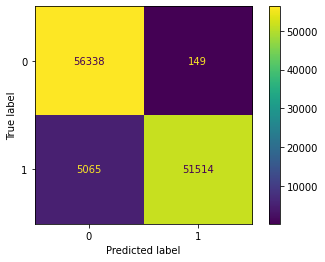

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

L'objectif maintenant consiste à choisir le meileur thresold pour minimiser les faux positif.

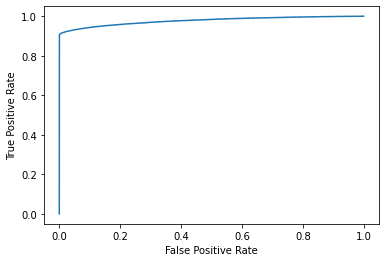

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=cv_results['estimator'][0].classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [63]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
thresholds

array([1.9999827 , 0.9999827 , 0.99996652, ..., 0.01352364, 0.01351636,
       0.00830745])

In [64]:
len(thresholds)

9485

In [65]:
tpr[900], fpr[900], thresholds[900]

(0.9105851994556284, 0.0027262910050100024, 0.49770260217501605)

Threshold value is: 0.4934684628476599


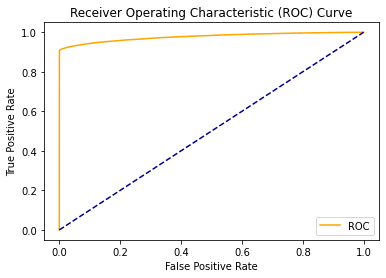

In [66]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
#print(tpr)
#print(fpr)
#print(thresholds)
#print(roc_auc_score(y_test, y_pred))
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [67]:
tpr[optimal_idx], fpr[optimal_idx], thresholds[optimal_idx]

(0.9108503154880786, 0.00290332288845221, 0.4934684628476599)

In [68]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>thresholds[optimal_idx]:
    y_pred.append(1) 
  else:
    y_pred.append(0)

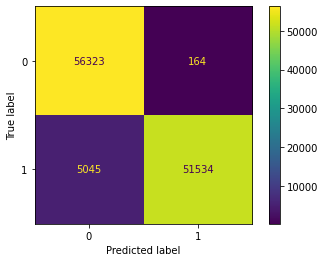

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

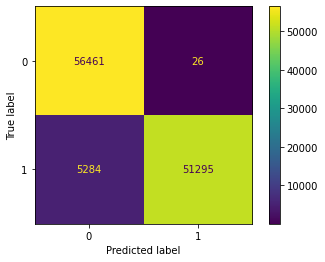

In [70]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>0.6:
    y_pred.append(1) 
  else:
    y_pred.append(0)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

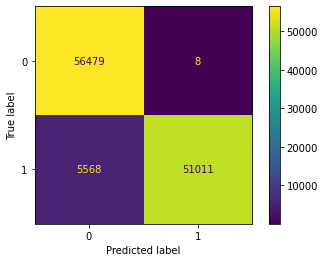

In [71]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>0.7:
    y_pred.append(1) 
  else:
    y_pred.append(0)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

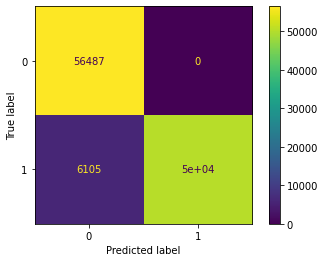

In [72]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>0.8:
    y_pred.append(1) 
  else:
    y_pred.append(0)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

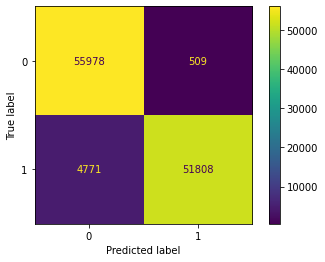

In [73]:
y_pred= []
for i in range(len(y_pred_proba)):
  if y_pred_proba[i][1]>0.4:
    y_pred.append(1) 
  else:
    y_pred.append(0)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Le meilleur seuil se situe entre 0.6 et 0.8. Dans ce projet, on porte le choix sur la valeur de 0.7.

Le modéle le plus performant

In [74]:
from sklearn.model_selection import cross_validate
model = lgb()
#model.fit(MinMaxScaler().fit_transform(X), y)
cv_results = cross_validate(model, MinMaxScaler().fit_transform(X_selected), y, cv=4, scoring='f1', return_estimator=True)

In [75]:
cv_results

{'fit_time': array([12.12064385, 12.21443725, 12.39580846, 11.61219931]),
 'score_time': array([0.58128476, 0.60856867, 0.60767746, 0.630831  ]),
 'estimator': [LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier()],
 'test_score': array([0.78388285, 0.99448412, 0.99475418, 0.99491919])}

Tester le model sur la base de test

In [76]:
application_test = pd.read_csv('application_test.csv')

In [77]:
columns_acc  = discrete_var + continuous_data + var_objet

In [78]:
application_test = application_test[columns_acc]

In [79]:
transformation_dict

{'discrete_variable': SimpleImputer(strategy='most_frequent'),
 'continuous_variable': SimpleImputer(strategy='median'),
 'cat_variable': SimpleImputer(strategy='most_frequent')}

In [80]:
application_test[discrete_var] = transformation_dict['discrete_variable'].transform(application_test[discrete_var])
application_test[continuous_data] = transformation_dict['continuous_variable'].transform(application_test[continuous_data])
application_test[var_objet] = transformation_dict['cat_variable'].transform(application_test[var_objet])

In [81]:
application_test[var_objet]

,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,NAME_EDUCATION_TYPE,NAME_INCOME_TYPE
0,No,Laborers,Unaccompanied,Cash loans,F,N,Y,TUESDAY,Kindergarten,House / apartment,Married,Higher education,Working
1,No,Low-skill Laborers,Unaccompanied,Cash loans,M,N,Y,FRIDAY,Self-employed,House / apartment,Married,Secondary / secondary special,Working
2,No,Drivers,Unaccompanied,Cash loans,M,Y,Y,MONDAY,Transport: type 3,House / apartment,Married,Higher education,Working
3,No,Sales staff,Unaccompanied,Cash loans,F,N,Y,WEDNESDAY,Business Entity Type 3,House / apartment,Married,Secondary / secondary special,Working
4,No,Laborers,Unaccompanied,Cash loans,M,Y,N,FRIDAY,Business Entity Type 3,House / apartment,Married,Secondary / secondary special,Working
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,No,Laborers,Unaccompanied,Cash loans,F,N,Y,WEDNESDAY,Other,House / apartment,Widow,Secondary / secondary special,Working
48740,No,Sales staff,Unaccompanied,Cash loans,F,N,N,MONDAY,Trade: type 7,House / apartment,Married,Secondary / secondary special,Commercial associate
48741,No,Laborers,Unaccompanied,Cash loans,F,Y,Y,WEDNESDAY,Business Entity Type 3,House / apartment,Married,Secondary / secondary special,Commercial associate
48742,No,Managers,Family,Cash loans,M,N,N,MONDAY,Self-employed,House / apartment,Married,Higher education,Commercial associate


In [82]:
for col in var_objet:
    application_test[col] = cat_col_transformation[col].transform(application_test[col])

In [83]:
X_test = fs.transform(application_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [84]:
X_test.shape

(48744, 70)

In [85]:
X_selected.shape

(565330, 70)

In [86]:
from sklearn.model_selection import cross_validate
scaler = MinMaxScaler()
#scaler.fit(X_selected)
cv_results = cross_validate(lgb(n_estimators=100), scaler.fit_transform(X_selected), y, cv=4, scoring='f1', return_estimator=True)

In [87]:
cv_results

{'fit_time': array([19.08921504, 12.47595978, 11.76002264, 11.69987464]),
 'score_time': array([0.58127093, 0.62206364, 0.59307075, 0.60249829]),
 'estimator': [LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier(),
  LGBMClassifier()],
 'test_score': array([0.78388285, 0.99448412, 0.99475418, 0.99491919])}

In [88]:
y_test = (cv_results['estimator'][0].predict_proba(scaler.transform(X_test))+\
               cv_results['estimator'][1].predict_proba(scaler.transform(X_test)) + \
               cv_results['estimator'][2].predict_proba(scaler.transform(X_test)) + \
               cv_results['estimator'][3].predict_proba(scaler.transform(X_test)))/4

In [ ]:
y_test[:,1]

array([0.13741185, 0.16300079, 0.13952115, ..., 0.07264247, 0.0388984 ,
       0.15010437])

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)


[[    0 48675]
 [    1    69]]


Dashboard